In [32]:
import sys
import numpy as np
import pandas as pd
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing.optim_preproc import OptimPreproc
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_adult
from aif360.algorithms.preprocessing.optim_preproc_helpers.distortion_functions import get_distortion_adult
from aif360.algorithms.preprocessing.optim_preproc_helpers.opt_tools import OptTools
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn import metrics, preprocessing
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display
np.random.seed(1)

In [33]:
df = pd.read_csv('adult.csv')

df = df.sample(n = 5000)
print(df.shape)

# check columns that have missing values\n
df.isin(['?']).sum(axis=0)

# replace missing values (?) to nan and then drop the columns
df['native.country'] = df['native.country'].replace('?',np.nan)
df['workclass'] = df['workclass'].replace('?',np.nan)
df['occupation'] = df['occupation'].replace('?',np.nan)

# dropping the NaN rows now
df.dropna(how='any',inplace=True)

df['income'] = df['income'].map({'<=50K': 0, '>50K': 1}).astype(int)
df['sex'] = df['sex'].map({'Male': 1, 'Female': 0}).astype(int)

(5000, 15)


(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

<Figure size 720x360 with 0 Axes>

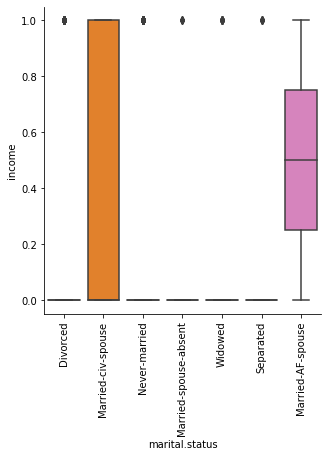

<Figure size 720x360 with 0 Axes>

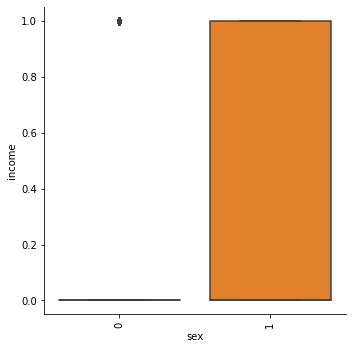

<Figure size 720x360 with 0 Axes>

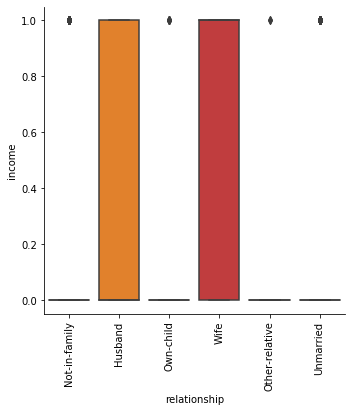

<Figure size 720x360 with 0 Axes>

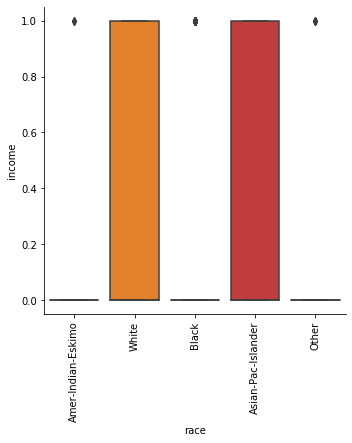

In [34]:
# Correlation of attributes with class label
plt.figure(figsize=(10,5))
sns.catplot(x="marital.status", y="income", kind="box", data=df)
plt.xticks(rotation=90)

plt.figure(figsize=(10,5))
sns.catplot(x="sex", y="income", kind="box", data=df)
plt.xticks(rotation=90)

plt.figure(figsize=(10,5))
sns.catplot(x="relationship", y="income", kind="box", data=df)
plt.xticks(rotation=90)

plt.figure(figsize=(10,5))
sns.catplot(x="race", y="income", kind="box", data=df)
plt.xticks(rotation=90)

In [35]:
# Data pre-processing

# For each category we made a separate column
df = pd.concat([df, pd.get_dummies(df['race'], prefix='race')],axis=1)
df = pd.concat([df, pd.get_dummies(df['marital.status'], prefix='marital')],axis=1)
df = pd.concat([df, pd.get_dummies(df['workclass'], prefix='workclass')],axis=1)
df = pd.concat([df, pd.get_dummies(df['relationship'], prefix='relationship')],axis=1)
df = pd.concat([df, pd.get_dummies(df['education'], prefix='education')],axis=1)
df = pd.concat([df, pd.get_dummies(df['occupation'], prefix='occupation')],axis=1)

# age binning
df['ageUnder18'] = np.where(df['age'] < 18, 1, 0)
df['age18to24'] = np.where((df['age'] >= 18) & (df['age'] <= 24), 1, 0)
df['age25to44'] = np.where((df['age'] >= 25) & (df['age'] <= 44), 1, 0)
df['age45to64'] = np.where((df['age'] >= 45) & (df['age'] <= 64), 1, 0)
df['ageAbove65'] = np.where(df['age'] >= 65, 1, 0)

# privileged, unprivileged groups
privileged_groups = [{'sex': 1}] # Male
unprivileged_groups = [{'sex': 0}] # Female

df = df.drop(columns=['workclass', 'fnlwgt', 'education', 'education.num', 'occupation', \
                      'relationship', 'marital.status', 'race', 'native.country', 'capital.gain', \
                      'capital.loss', 'hours.per.week', 'age'])

In [36]:
# df.describe()
df
# class imbalance: 75th percentile of income is 0.

,sex,income,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,marital_Divorced,marital_Married-AF-spouse,marital_Married-civ-spouse,...,occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,ageUnder18,age18to24,age25to44,age45to64,ageAbove65
9646,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
709,1,1,0,0,0,0,1,0,0,1,...,0,1,0,0,0,0,0,1,0,0
7385,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
16671,1,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
21932,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30796,1,0,0,0,0,0,1,0,0,1,...,0,0,1,0,0,0,0,1,0,0
2532,1,1,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
32467,1,1,0,1,0,0,0,0,0,1,...,0,0,0,1,0,0,0,1,0,0
8138,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [37]:
# Let's consider is as a black-box for now. Just provides some metrics
def get_metrics(test_df, y_pred, unprivileged_groups, privileged_groups):
    # BLD constructor is taking arguments of Structured dataset
    test_bld = BinaryLabelDataset(df=test_df, label_names=['income'], protected_attribute_names=['sex'])
    
    # Made a copy of the the bld dataset
    pred_data = test_bld.copy()
    pred_data.labels = y_pred

    # Using classification metric because we have 2 binary label datasets
    metric_selection = ClassificationMetric(
                    test_bld, pred_data,
                    unprivileged_groups=unprivileged_groups,
                    privileged_groups=privileged_groups)
    
    tnr_diff = metric_selection.true_negative_rate(1) - metric_selection.true_negative_rate(0)
    
    return [metric_selection.true_positive_rate_difference(), \
        metric_selection.statistical_parity_difference(),\
        tnr_diff,\
        metric_selection.accuracy()]

In [38]:
# X is basically used for predicting the y value
# Here X is all the columns without income column and y is just the income column

X = df.drop(columns='income')
y = df['income']

# We are using K-Cross Validation for training the model

num_k = 5 # number of folds for cross-validation

# Metrics for each set of (train and test) sample
metrics = [None] * num_k

# Regression on original data
k_fold = KFold(n_splits=num_k, random_state=None, shuffle=False)
for k, (train, test) in enumerate(k_fold.split(X, y)):
    # Here train and test are the list of indices on which split is done
   
    # take out test set from X
    test_df = X.iloc[test].copy()
    test_df['income'] = y.iloc[test]
    
    reg = LogisticRegression(max_iter=300, solver = 'lbfgs')
    reg.fit(X.iloc[train], y.iloc[train])
    y_pred = reg.predict(X.iloc[test])
    metrics[k] = get_metrics(test_df, y_pred, unprivileged_groups, privileged_groups)

print("Results: Original")
mf_orig = pd.DataFrame(metrics, columns = ['TruePositiveRateDiff', 'StatisticalParityDiff', \
                                      'TrueNegativeRateDiff', 'Accuracy'])
mf_orig.mean()

Results: Original


TruePositiveRateDiff    -0.174627
StatisticalParityDiff   -0.201517
TrueNegativeRateDiff    -0.093165
Accuracy                 0.832288
dtype: float64

In [39]:
# An attempt to classify the batch of maried males being responsible for bias
# and see if the fairness is additive

X = df.drop(columns='income')
y = df['income']

num_k = 5
metrics = [None] * num_k

k_fold = KFold(n_splits=num_k, random_state=None, shuffle=False)
for k, (train, test) in enumerate(k_fold.split(X, y)):
    test_df = df.iloc[test].copy()
    train_df = df.iloc[train].copy()
    
#     Remove all males
    train_df.drop(train_df[train_df.sex == 1].index, inplace=True) 

#     Remove married males
#     train_df.drop(train_df[(train_df.sex == 1) & (train_df['marital_Never-married'] !=1)]
#                   .index, inplace=True)
    
    reg = LogisticRegression(max_iter=300, solver = 'lbfgs')
    reg.fit(train_df.drop(columns='income'), train_df['income'])
    y_pred = reg.predict(test_df.drop(columns='income'))
    metrics[k] = get_metrics(test_df, y_pred, unprivileged_groups, privileged_groups)

print("Results: Removed rows with predicate")
mf_predicate = pd.DataFrame(metrics, columns = ['TruePositiveRateDiff', 'StatisticalParityDiff', \
                                      'TrueNegativeRateDiff', 'Accuracy'])
mf_predicate.mean()

Results: Removed rows with predicate


TruePositiveRateDiff     0.055278
StatisticalParityDiff   -0.084784
TrueNegativeRateDiff    -0.028394
Accuracy                 0.814348
dtype: float64

In [40]:
# Compute influence of each row by deleting it and retraining the model
train, test = train_test_split(df, test_size=0.3)
X_train = train.drop(columns='income')
y_train = train['income']

X_test = test.drop(columns='income')
y_test = test['income']

infs = pd.DataFrame(columns = ['TruePositiveRateDiff', 'StatisticalParityDiff', \
                                      'TrueNegativeRateDiff', 'Accuracy'])
reg = LogisticRegression(max_iter=200, solver = 'lbfgs')
for i in range(0, len(X_train)):
    X_train_remove_one_row = X_train.drop(X_train.index[i])
    y_train_remove_one_row = y_train.drop(y_train.index[i])
    reg.fit(X_train_remove_one_row, y_train_remove_one_row)
    y_pred = reg.predict(X_test)
    metrics = get_metrics(test, y_pred, unprivileged_groups, privileged_groups)
    inf = mf_orig.mean() - metrics
    infs.loc[len(infs)] = inf
    # print(inf)
    print("influence of: "+ str(i)+ " out of " + str(len(X_train)))

infs = pd.DataFrame(infs)
print("done")

done


[Text(2220.1556603773583, 1494.8999999999999, 'education_Prof-school <= 0.5\nmse = 0.004\nsamples = 3238\nvalue = 3.088'),
 Text(1179.1698113207547, 1223.1, 'workclass_Federal-gov <= 0.5\nmse = 0.004\nsamples = 3189\nvalue = 3.09'),
 Text(589.5849056603773, 951.3, 'workclass_State-gov <= 0.5\nmse = 0.004\nsamples = 3090\nvalue = 3.089'),
 Text(294.79245283018867, 679.4999999999999, 'occupation_Protective-serv <= 0.5\nmse = 0.003\nsamples = 2961\nvalue = 3.09'),
 Text(147.39622641509433, 407.6999999999998, 'workclass_Local-gov <= 0.5\nmse = 0.002\nsamples = 2914\nvalue = 3.091'),
 Text(73.69811320754717, 135.89999999999986, 'mse = 0.002\nsamples = 2728\nvalue = 3.089'),
 Text(221.09433962264148, 135.89999999999986, 'mse = 0.006\nsamples = 186\nvalue = 3.126'),
 Text(442.18867924528297, 407.6999999999998, 'workclass_Local-gov <= 0.5\nmse = 0.05\nsamples = 47\nvalue = 3.024'),
 Text(368.49056603773585, 135.89999999999986, 'mse = 0.023\nsamples = 21\nvalue = 3.102'),
 Text(515.886792452830

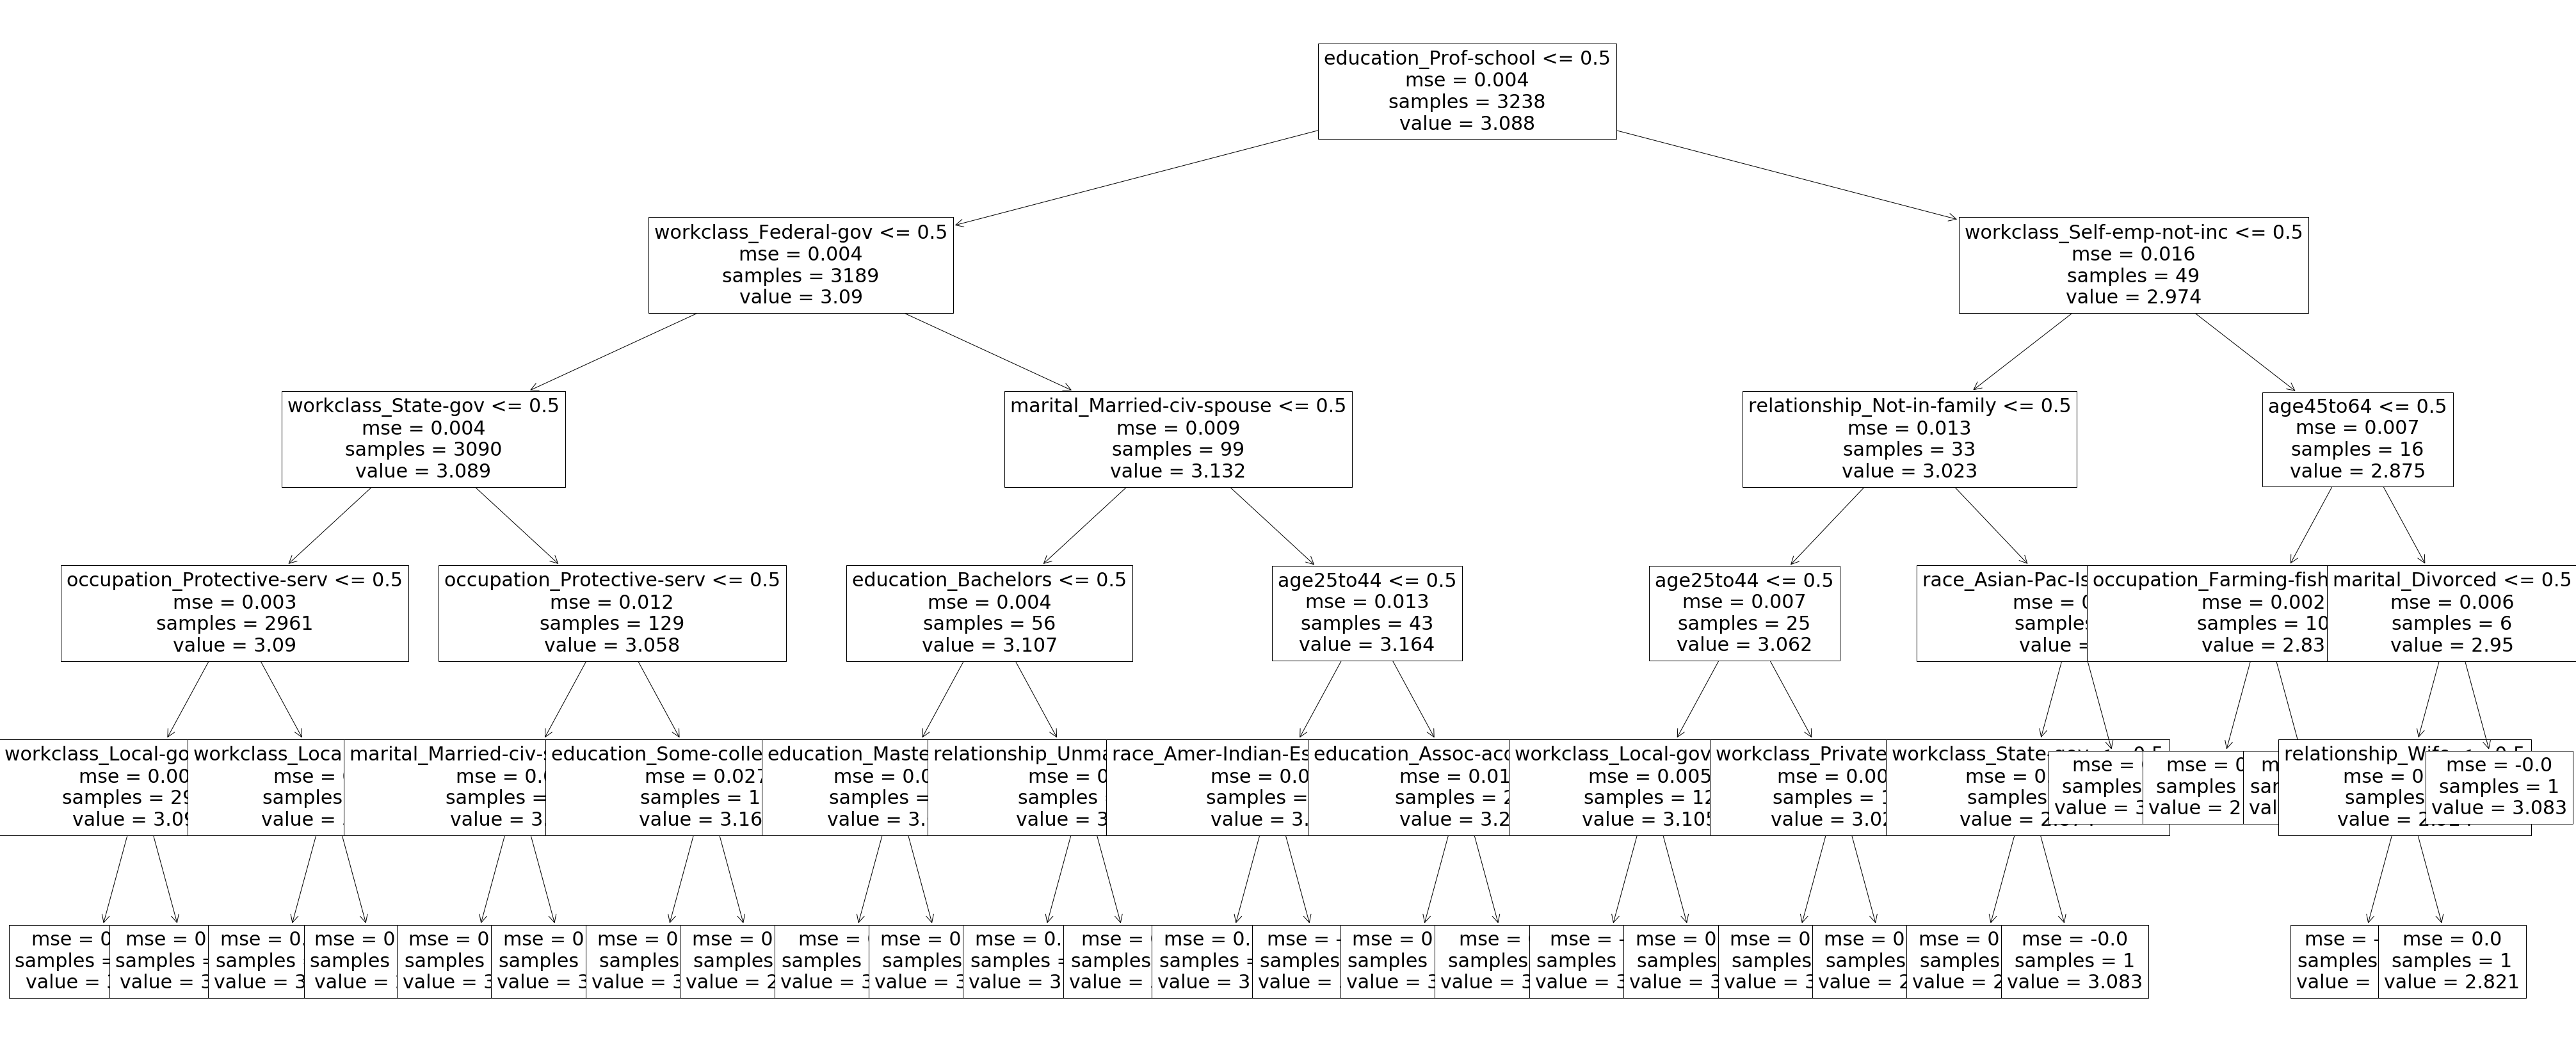

In [41]:
norm_infs = infs['StatisticalParityDiff'].copy()
norm_infs = [float(i)*10000/sum(norm_infs) for i in norm_infs]
regressor = DecisionTreeRegressor(max_depth=5)
regressor.fit(X_train, norm_infs)
plt.figure(figsize=(70,30))
plot_tree(regressor, feature_names=X_train.columns, fontsize=30)

[Text(2077.659574468085, 1494.8999999999999, 'workclass_Federal-gov <= 0.5\nmse = 0.001\nsamples = 3238\nvalue = 3.088'),
 Text(1163.4893617021276, 1223.1, 'education_Assoc-voc <= 0.5\nmse = 0.001\nsamples = 3137\nvalue = 3.087'),
 Text(664.8510638297872, 951.3, 'workclass_State-gov <= 0.5\nmse = 0.001\nsamples = 3012\nvalue = 3.088'),
 Text(332.4255319148936, 679.4999999999999, 'occupation_Protective-serv <= 0.5\nmse = 0.0\nsamples = 2886\nvalue = 3.089'),
 Text(166.2127659574468, 407.6999999999998, 'workclass_Without-pay <= 0.5\nmse = 0.0\nsamples = 2839\nvalue = 3.09'),
 Text(83.1063829787234, 135.89999999999986, 'mse = 0.0\nsamples = 2838\nvalue = 3.09'),
 Text(249.31914893617022, 135.89999999999986, 'mse = 0.0\nsamples = 1\nvalue = 3.233'),
 Text(498.63829787234044, 407.6999999999998, 'marital_Separated <= 0.5\nmse = 0.004\nsamples = 47\nvalue = 3.062'),
 Text(415.531914893617, 135.89999999999986, 'mse = 0.003\nsamples = 45\nvalue = 3.067'),
 Text(581.7446808510638, 135.8999999999

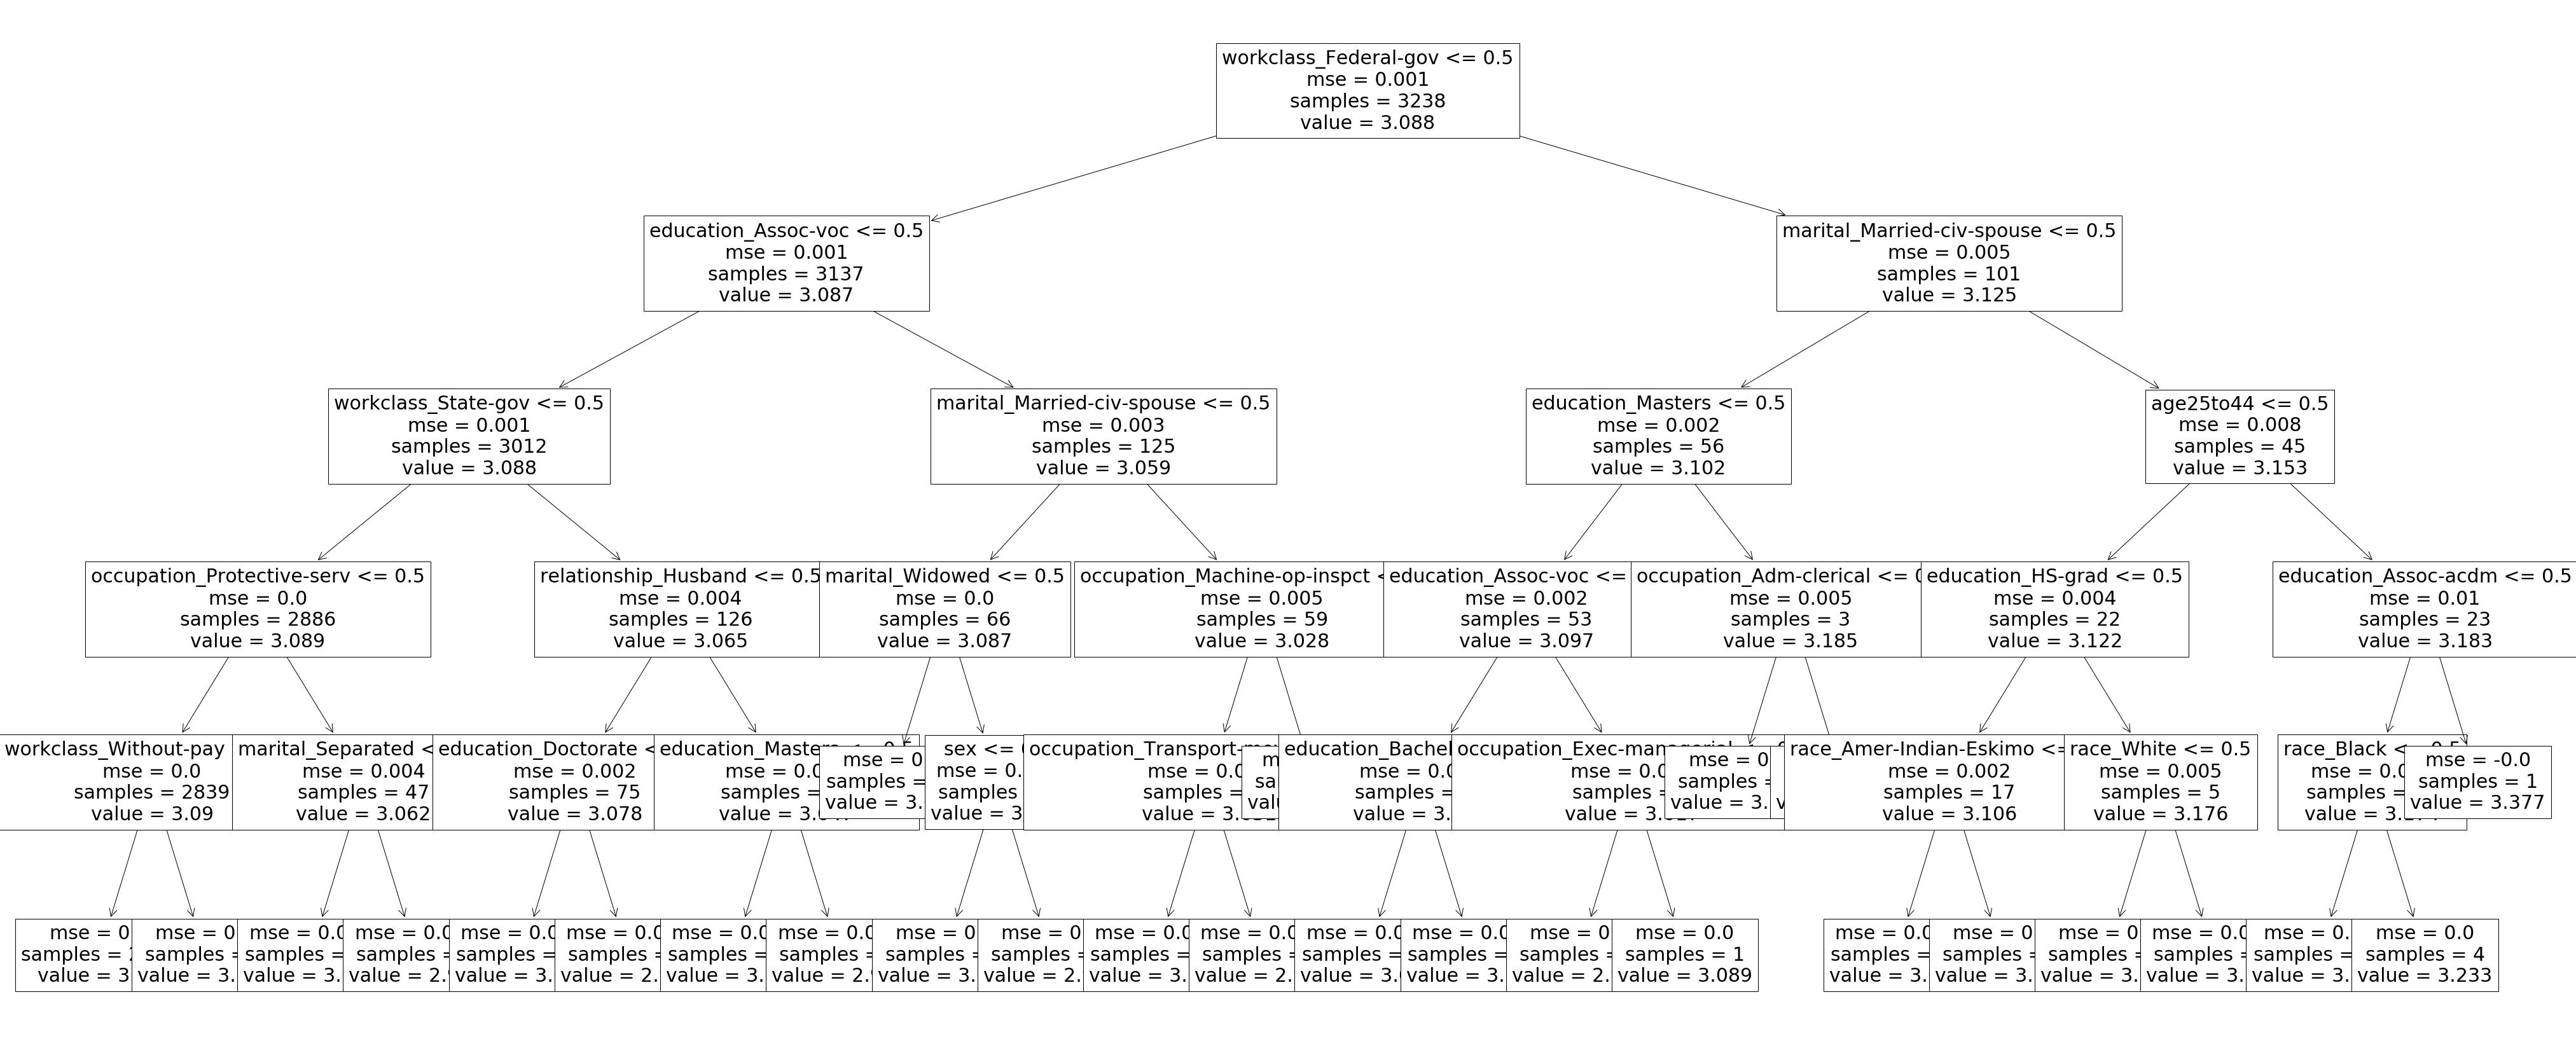

In [42]:
tpr_infs = infs['TruePositiveRateDiff'].copy()
tpr_infs = [float(i)*10000/sum(tpr_infs) for i in tpr_infs]
tpr_regressor = DecisionTreeRegressor(max_depth=5)
tpr_regressor.fit(X_train, tpr_infs)
plt.figure(figsize=(70,30))
plot_tree(tpr_regressor, feature_names=X_train.columns, fontsize=30)

In [ ]:
tpr_infs = infs['TruePositiveRateDiff'].copy()
tpr_infs = [float(i)*10000/sum(tpr_infs) for i in tpr_infs]
tpr_regressor = DecisionTreeRegressor(max_depth=5)
tpr_regressor.fit(X_train, tpr_infs)
plt.figure(figsize=(70,30))
plot_tree(tpr_regressor, feature_names=X_train.columns, fontsize=30)

In [ ]:
tnr_infs = infs['TrueNegativeRateDiff'].copy()
tnr_infs = [float(i)*10000/sum(tnr_infs) for i in tnr_infs]
tnr_regressor = DecisionTreeRegressor(max_depth=5)
tnr_regressor.fit(X_train, tnr_infs)
plt.figure(figsize=(70,30))
plot_tree(tnr_regressor, feature_names=X_train.columns, fontsize=30)

In [ ]:
acc_infs = infs['Accuracy'].copy()
acc_infs = [float(i)*10000/sum(acc_infs) for i in acc_infs]
acc_regressor = DecisionTreeRegressor(max_depth=5)
acc_regressor.fit(X_train, acc_infs)
plt.figure(figsize=(70,30))
plot_tree(acc_regressor, feature_names=X_train.columns, fontsize=30)